In [9]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from universal_transcoder.plots_and_logs import *
from universal_transcoder.calculations.energy_intensity import *
from processing_constants import *
import parameter_utils as pu
import warnings

In [10]:
def get_width_and_angular_error(cloud_points, S, output_layout):
    radial_i        = radial_I_calculation(cloud_points, S, output_layout)
    transverse_i    = transverse_I_calculation(cloud_points, S, output_layout)
    
    angular_error_calc  = angular_error(radial_i, transverse_i)
    width_calc          = width_angle(radial_i)

    return angular_error_calc, width_calc

In [11]:
def compute_q_s(angular_error, source_width):
    
    ae_mean     = np.mean(angular_error)            # mean angular error
    ae_90       = np.percentile(angular_error, 90)  # 90th percentile
    sw_median   = np.median(source_width)           # median source width

    hist_ae, bins_ae = np.histogram(angular_error, 
                                    bins=np.arange(0, 91, 5), 
                                    density=True)
    
    # Calculates the percentage of angles that have an angular error under 15° 
    cdf_ae      = np.cumsum(hist_ae) * np.diff(bins_ae)
    ae_under_15 = cdf_ae[np.searchsorted(bins_ae[1:], 15)]

    def normalize_inverse(x, min_val, max_val):
        return np.clip((max_val - x) / (max_val - min_val), 0, 1)

    score_ae_mean   = normalize_inverse(ae_mean, 0, 45)
    score_ae_90     = normalize_inverse(ae_90, 0, 90)
    score_under_15  = ae_under_15

    w_mean     = 0.4
    w_90       = 0.4
    w_under_15 = 0.2

    q_s = (score_ae_mean * w_mean +
           score_ae_90   * w_90 +
           score_under_15 * w_under_15) * 100

    return q_s, sw_median   

In [12]:
def create_df_from_files(base_dir: str):
    
    entries = []

    for folder_name in tqdm(os.listdir(base_dir)):
        
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue

        seed        = int(folder_name.split("_")[-1])
        npz_path    = os.path.join(folder_path, f"matrix_data_{seed}.npz")
        json_path   = os.path.join(folder_path, f"metadata_{seed}.json")
        xml_path    = os.path.join(folder_path, f"y_parameters_{seed}.xml")

        with np.load(npz_path) as data:
            entry = {
                "seed": seed,
                "folder": folder_path,
                "S": data["S"],
                "G": data["G"],
                "T": data["T"],
                "D": data["D"],
            }

        if os.path.exists(xml_path):
            with open(xml_path, "r", encoding="utf-8") as f:
                xml_string  = f.read()
                parsed_xml  = pu.usat_xml_to_dict(xml_string)
                entry["y"]  = parsed_xml

        if os.path.exists(json_path):
            with open(json_path, "r") as f:
                metadata    = json.load(f)
                coordinates = pu.restore_coordinates(metadata)
            entry.update(coordinates)

        ang_error, source_width = get_width_and_angular_error(entry[CLOUD_POINTS], 
                                                              entry["S"], 
                                                              entry[OUTPUT_LAYOUT])
        q_s, median_sw = compute_q_s(ang_error, source_width)
        entry[QUALITY_SCORE]            = round(q_s, 2)
        entry[APPARENT_SOURCE_WIDTH]    = round(median_sw, 2)

        entries.append(entry)

    return pd.DataFrame(entries)

In [13]:
warnings.filterwarnings("ignore")
df = create_df_from_files("random_usat_decodings")

y_expanded = df["y"].apply(pd.Series)
df = pd.concat([df.drop(columns=["y"]), y_expanded], axis=1)

enc_settings_exp = df[ENCODING_SETTINGS].apply(pd.Series)
df = pd.concat([df.drop(columns=[ENCODING_SETTINGS]), enc_settings_exp], axis=1)

ambi_order_in_exp = df[INPUT_AMBISONICS].apply(pd.Series)
df = pd.concat([df.drop(columns=[INPUT_AMBISONICS]), ambi_order_in_exp], axis=1)

ambi_order_out_exp = df[OUTPUT_AMBISONICS].apply(pd.Series)
df = pd.concat([df.drop(columns=[OUTPUT_AMBISONICS]), ambi_order_out_exp], axis=1)

output_layout_desc_exp = df[OUTPUT_LAYOUT_DESC].apply(pd.Series)
df = pd.concat([df.drop(columns=[OUTPUT_LAYOUT_DESC]), output_layout_desc_exp], axis=1)

coefficients_exp = df[COEFFICIENTS].apply(pd.Series)
df = pd.concat([df.drop(columns=[COEFFICIENTS]), coefficients_exp], axis=1)

'''
IN_PHASE_QUADRATIC      = "inPhaseQuadratic"
SYMMETRY_QUADRATIC      = "symmetryQuadratic"
IN_PHASE_LINEAR         = "inPhaseLinear"
SYMMETRY_LINEAR         = "symmetryLinear"
TOTAL_GAINS_LINEAR      = "totalGainsLinear"
TOTAL_GAINS_QUADRATIC   = "totalGainsQuadratic"
'''
columns_to_omit = [
    parameter_to_coefficient_key[PRESSURE],
    parameter_to_coefficient_key[RADIAL_VELOCITY],
    parameter_to_coefficient_key[TRANSVERSE_VELOCITY],
    parameter_to_coefficient_key[IN_PHASE_LINEAR],
    parameter_to_coefficient_key[SYMMETRY_LINEAR],
    parameter_to_coefficient_key[TOTAL_GAINS_LINEAR],
    parameter_to_coefficient_key[TOTAL_GAINS_QUADRATIC],
    INPUT_SPEAKER_LAYOUT,
    OUTPUT_SPEAKER_LAYOUT,
    OUTPUT_LAYOUT,
    CLOUD_PLOTS,
    CLOUD_POINTS,
    AMBISONICS_ORDER_OUT,
    INPUT_LAYOUT_DESC,
    "S",
    "G",
    "T",
    "D",
    ]

df_filtered = df.drop(columns=columns_to_omit)

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)           # Don't wrap output (optional but helpful)
df_filtered.head(10)


100%|██████████| 41/41 [00:01<00:00, 20.66it/s]


,seed,folder,quality_score,median_source_width,InputType,OutputType,AmbisonicsOrderIn,OutputLayoutDescription,energy,radial_intensity,transverse_intensity,in_phase_quad,symmetry_quad
0,3341001009,random_usat_decodings/usat_3341001009,53.00,31.170000,Ambisonics,SpeakerLayout,5,layout_7_0_4,4.0,4.0,2.0,14.0,8.0
1,573330905,random_usat_decodings/usat_573330905,54.68,33.180000,Ambisonics,SpeakerLayout,5,layout_7_0_4,6.0,1.0,3.0,7.0,6.0
2,1840549058,random_usat_decodings/usat_1840549058,51.79,33.259998,Ambisonics,SpeakerLayout,5,layout_7_0_4,7.0,4.0,2.0,14.0,1.0
3,989216716,random_usat_decodings/usat_989216716,38.80,26.370001,Ambisonics,SpeakerLayout,5,layout_7_0_4,6.0,3.0,0.0,13.0,7.0
4,2729534538,random_usat_decodings/usat_2729534538,52.14,30.860001,Ambisonics,SpeakerLayout,5,layout_7_0_4,4.0,3.0,1.0,13.0,3.0
5,2116375062,random_usat_decodings/usat_2116375062,38.73,26.309999,Ambisonics,SpeakerLayout,5,layout_7_0_4,4.0,3.0,0.0,11.0,4.0
6,1383437304,random_usat_decodings/usat_1383437304,50.39,32.380001,Ambisonics,SpeakerLayout,5,layout_7_0_4,2.0,4.0,2.0,7.0,1.0
7,718869916,random_usat_decodings/usat_718869916,38.18,26.340000,Ambisonics,SpeakerLayout,5,layout_7_0_4,3.0,1.0,0.0,7.0,6.0
8,358388171,random_usat_decodings/usat_358388171,53.00,31.200001,Ambisonics,SpeakerLayout,5,layout_7_0_4,11.0,2.0,1.0,7.0,11.0
9,2114988251,random_usat_decodings/usat_2114988251,53.01,31.170000,Ambisonics,SpeakerLayout,5,layout_7_0_4,3.0,2.0,1.0,10.0,2.0


# Distribution of Quality Scores

### Highest Quality Scores

In [14]:
# Show top 3 rows with highest quality scores
df_filtered.nlargest(3, QUALITY_SCORE)

,seed,folder,quality_score,median_source_width,InputType,OutputType,AmbisonicsOrderIn,OutputLayoutDescription,energy,radial_intensity,transverse_intensity,in_phase_quad,symmetry_quad
30,1148830771,random_usat_decodings/usat_1148830771,99.98,74.430000,Ambisonics,SpeakerLayout,5,layout_7_0_4,5.0,0.0,2.0,11.0,2.0
39,1432424615,random_usat_decodings/usat_1432424615,99.96,78.589996,Ambisonics,SpeakerLayout,5,layout_7_0_4,13.0,0.0,1.0,5.0,9.0
24,2965495403,random_usat_decodings/usat_2965495403,99.94,71.650002,Ambisonics,SpeakerLayout,5,layout_7_0_4,16.0,0.0,2.0,14.0,3.0


### Lowest Quality Scores

In [15]:
df_filtered.nsmallest(3, QUALITY_SCORE)

,seed,folder,quality_score,median_source_width,InputType,OutputType,AmbisonicsOrderIn,OutputLayoutDescription,energy,radial_intensity,transverse_intensity,in_phase_quad,symmetry_quad
37,2306466726,random_usat_decodings/usat_2306466726,6.23,65.160004,Ambisonics,SpeakerLayout,5,layout_7_0_4,3.0,0.0,0.0,16.0,5.0
31,2206093678,random_usat_decodings/usat_2206093678,6.64,68.050003,Ambisonics,SpeakerLayout,5,layout_7_0_4,5.0,0.0,0.0,18.0,3.0
7,718869916,random_usat_decodings/usat_718869916,38.18,26.340000,Ambisonics,SpeakerLayout,5,layout_7_0_4,3.0,1.0,0.0,7.0,6.0


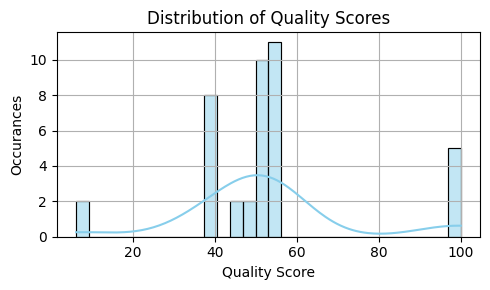

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 3))
sns.histplot(df_filtered[QUALITY_SCORE], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Quality Scores")
plt.xlabel("Quality Score")
plt.ylabel("Occurances")
plt.grid(True)
plt.tight_layout()
plt.show()